<a href="https://colab.research.google.com/github/sleepsim/Week4-Neural_Network/blob/main/Assignment4_pandres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

Assignment 3 - IAT481 SP 2024\
Pocholo Andres\
pandres@sfu.ca\
github.com/sleepsim

https://github.com/sleepsim/Week3-Machine_Learning
___



# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

All required imports stored in one code block

In [ ]:
#importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')
from joblib import parallel_backend

#SKLearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Neural network models
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold



## Load Files

In [ ]:
features=pd.read_excel('/content/drive/MyDrive/IAT481/featuresCombined.xlsx',index_col=0)
emotions=pd.read_excel('/content/drive/MyDrive/IAT481/emotionsCombined.xlsx',index_col=0)

In [ ]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
print(f'\nEmotion samples represented: {features.shape[0]}')
features_df = pd.DataFrame(features)
labels_df=pd.DataFrame(emotions)


Audio samples represented: 1508
Numerical features extracted per sample: 180

Emotion samples represented: 1508


## Feature Scaling

In [ ]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

# print("Before Scaling \n\n")
# print_features(features_df)

In [ ]:
scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

print("After Scaling \n\n")
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

After Scaling 


Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


# Neural Network Setup

## Data Split 80/20

First thing's first I have to do split the data like we have done in previous weeks 80/20 for all three datasaets

In [ ]:
from sklearn.model_selection import train_test_split
############# Unscaled test/train set #############
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=69
)

## Default MLP Model

I'm going to try how the default model works for all three datasets using my usual random state of = 10101

In [ ]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 10101
)
#unscaled
model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

#scaled
model.fit(X_train_scaled, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Scaled MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')

#minmax
model.fit(X_train_minmax, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'MinMax MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax MLP Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%\n')

Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Unscaled MLP Model's accuracy on training set is 63.27%
Unscaled MLP Model's accuracy on test set is 48.34%

Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
Scaled MLP Model's accuracy on training set is 90.13%
Scaled MLP Model's accuracy on test set is 68.87%

Possible emotions predicted by model:['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad']
MinMax MLP Model's accuracy on training set is 61.77%
MinMax MLP Model's accuracy on test set is 51.99%



According to the results above, the scaled dataset performs the best out of the three with a result of
- Training: 90.13%
- Test: 68.87%

In comparison, the best performing dataset from the Lab RAVDESS only example is also the scaled version with a score of
- Training: 99.39%
- Test: 65.51%

Because of this, like the lab example, I will go ahead and use the scaled features as my default dataset

## Finding the best parameters

Using GridSearch by scikit, I'll search for the best parameters that gave the best score. The parameters tested will be exactly the same as the lab with the exception of using the random_state = 10101

In [ ]:
# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=10101
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,), (300,),(100,50,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=2,
    n_jobs=-1,
    verbose=10)

# Fit the models specified by the parameter grid
with parallel_backend('multiprocessing'):
    grid.fit(X_train_scaled, y_train)

# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 1/2; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd[CV 2/2; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd

Fitting 2 folds for each of 48 candidates, totalling 96 fits
[CV 2/2; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.493 total time=   4.4s
[CV 1/2; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam[CV 1/2; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.489 total time=   4.4s

[CV 2/2; 2/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam
[CV 1/2; 2/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=adam;, score=0.615 total time=   3.9s
[CV 1/2; 3/48] START activation=relu, alpha=0.001, h

In [ ]:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'solver': 'adam'}

{'activation': 'relu',
 'alpha': 0.01,
 'hidden_layer_sizes': (300,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

With the best parameters found, I'll run the model again with them

In [ ]:
model = MLPClassifier(
    activation = 'relu',
    alpha = 0.01,
    hidden_layer_sizes = (300,),
    learning_rate = 'adaptive',
    solver = 'adam',
    random_state = 10101
)

model.fit(X_train_scaled, y_train)

print(f'Optimized MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Optimized MLP Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')

Optimized MLP Model's accuracy on training set is 96.60%
Optimized MLP Model's accuracy on test set is 71.19%



The model improved from

- 90.13% -> 96.60%
- 68.87% -> 71.19%

## Loss Curve

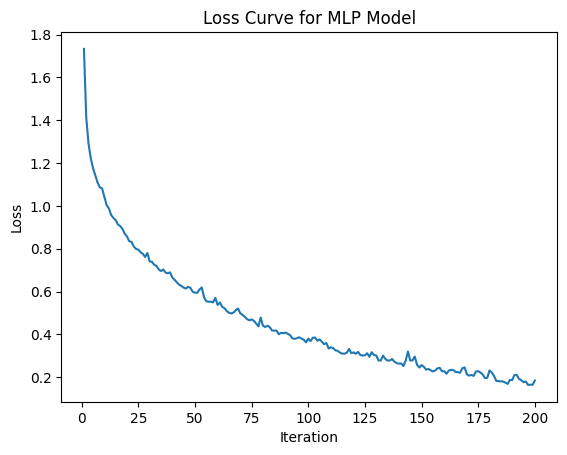

In [ ]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

## Confusion Matrix

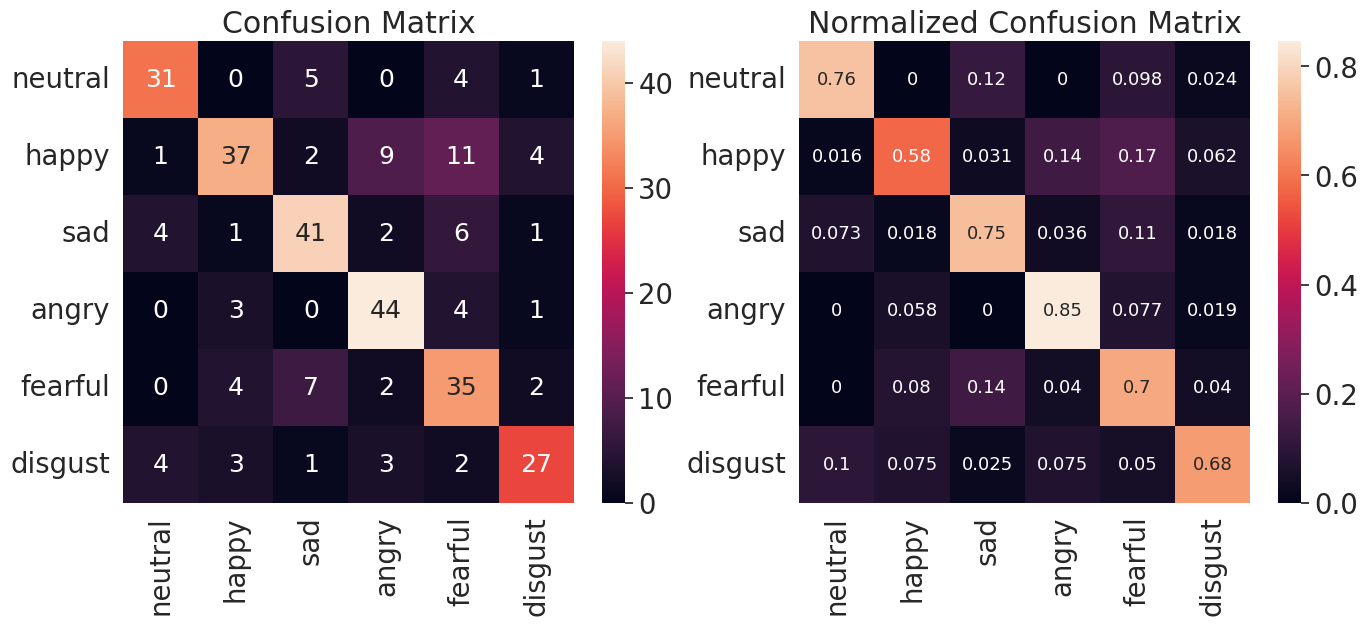

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test_scaled)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','happy','sad','angry','fearful','disgust']
emotion_name = [emotion for emotion in emotion_list]

# angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad'

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

From the graphic above, you can tell that the model is good at predicting the emotion angry. The RAVDESS set also predicted angry as well but it predicted an emotion we removed during data cleaning which was calm.

The worst performing emotion was happy which for some reason had a lot of false positives for fearful.

## Precision Recall F-Score

In [ ]:
y_pred = model.predict(X_test_scaled)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  71.192%
Test Set Precision score =  72.097%
Test Set Recall score =  71.681%
Test Set F-score score =  71.4%


## K Fold validation

In [ ]:
kfold = StratifiedKFold(
    n_splits=10,
    random_state=69,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train_scaled)
y_train=pd.DataFrame(y_train)
for train_indices, test_indices in kfold.split(X_train,y_train):

    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    test_x=X_train.iloc[test_indices]
    test_y=y_train.iloc[test_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(test_x, test_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
71.07%
68.60%
69.42%
72.73%
66.94%
64.46%
75.83%
75.83%
71.67%
74.17%
Mean score of KFold CV for MLP: 71.07% ± 3.57%


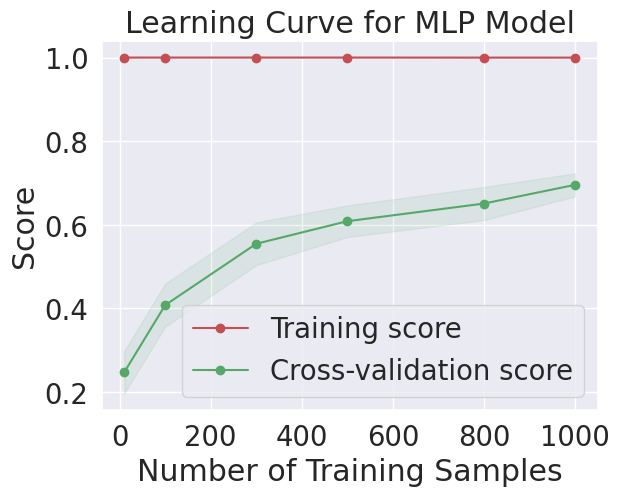

In [ ]:
from sklearn.model_selection import learning_curve
# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=69,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

# Conclusion